In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
import shap
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


operating_system ='mac'
if operating_system == 'win':
    path = f'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = f'/Users/fabienaugsburger/Documents/GitHub/master-project/'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#import the X and y data in the format .npy
dataset = 'X_y_EU_1h'

dataset_type = '_all_stat' #all_stat means the 4 stats, 2 means the storms one after another and nothing means only the mean stat

X_train = np.load(f'{path}DATASETS/{dataset}/X_train{dataset_type}.npy')
y_train = np.load(f'{path}DATASETS/{dataset}/y_train{dataset_type}.npy')
X_test = np.load(f'{path}DATASETS/{dataset}/X_test{dataset_type}.npy')
y_test = np.load(f'{path}DATASETS/{dataset}/y_test{dataset_type}.npy')
X_validation = np.load(f'{path}DATASETS/{dataset}/X_validation{dataset_type}.npy')
y_validation = np.load(f'{path}DATASETS/{dataset}/y_validation{dataset_type}.npy')

masking_value = 0#2**0.5

def preprocess_X_data(X):
    # Reshape the X array
    reshape = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
    
    # Fit the StandardScaler to the reshaped X array
    reshape_std = StandardScaler().fit_transform(reshape)

    # Create the mask indicating where NaN values were originally located
    mask_X = np.isnan(X).reshape(X.shape[0], X.shape[1], X.shape[2])
    
    # Replace NaN values with -1e9 in X
    reshape_std[np.isnan(reshape_std)] = masking_value
    
    # Reshape the data back to the original shape for X
    X_processed = reshape_std.reshape(X.shape[0], X.shape[1], X.shape[2])

    return X_processed, mask_X

def preprocess_y_data(y):
    # Reshape the y array

    if dataset_type == '_all_stat':
        reshape = y.reshape(y.shape[0] * y.shape[1], y.shape[2])

        mask_y = np.isnan(y).reshape(y.shape[0], y.shape[1], y.shape[2])

        # Replace NaN values with -1e9 in X
        reshape[np.isnan(reshape)] = masking_value
        
        # Reshape the y array
        y_processed = reshape.reshape(y.shape[0], y.shape[1], y.shape[2])
    else:

    #reshape = y.reshape(y.shape[0] * y.shape[1], 1)

    # Fit the StandardScaler to the y array
    #reshape_std = StandardScaler().fit_transform(reshape)

    # Create the mask indicating where NaN values were originally located
        mask_y = np.isnan(y).reshape(y.shape[0], y.shape[1])

        # Replace NaN values with -1e9 in X
        y[np.isnan(y)] = masking_value
        
        # Reshape the y array
        y_processed = y.reshape(y.shape[0], y.shape[1], 1)
    
    return y_processed, mask_y

X_train, M_X_train = preprocess_X_data(X_train)
X_test, M_X_test = preprocess_X_data(X_test)
X_validation, M_X_validation = preprocess_X_data(X_validation)

'''if dataset_type == '0':
    y_train, M_y_train = preprocess_X_data(y_train)
    y_test, M_y_test = preprocess_X_data(y_test)
    y_validation, M_y_validation = preprocess_X_data(y_validation)'''

y_train, M_y_train = preprocess_y_data(y_train)
y_test, M_y_test = preprocess_y_data(y_test)
y_validation, M_y_validation = preprocess_y_data(y_validation)

y_train_mean = y_train[:,:,2].reshape(y_train.shape[0], y_train.shape[1], 1)
y_test_mean = y_test[:,:,2].reshape(y_test.shape[0], y_test.shape[1], 1)
y_validation_mean = y_validation[:,:,2].reshape(y_validation.shape[0], y_validation.shape[1], 1)

features = pd.read_csv(path+'variable_list_all.csv', header=None)

Num GPUs Available:  1


/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the custom WeightedMSE class
class WeightedMSE(tf.keras.losses.Loss):
    """ 
    Calculate a weighted MSE. This loss gives you control to weight the 
    pixels that are > 0 differently than the pixels that are 0 in y_true. This
    class is subclassed from tf.keras.lossess.Loss to hopefully enable 
    'stateful'-ness.
 
    weights[0] is the weight for non-zero pixels
    weights[1] is the weight for zero pixels.
    """
    def __init__(self, weights=[1.0, 1.0], name="custom_mse", **kwargs):
        super(WeightedMSE, self).__init__(name=name, **kwargs)
        # store weights
        self.w1 = weights[0]
        self.w2 = weights[1]

    def call(self, y_true, y_pred):
        # build weight_matrix 
        ones_array = tf.ones_like(y_true)
        weights_for_nonzero = tf.math.multiply(ones_array, self.w1)
        weights_for_zero = tf.math.multiply(ones_array, self.w2)
        weight_matrix = tf.where(tf.greater(y_true, 0), weights_for_nonzero, weights_for_zero)
        loss = tf.math.reduce_mean(tf.math.multiply(weight_matrix, tf.math.square(tf.math.subtract(y_pred, y_true))))
        return loss

# Define the model
model_WSE_G = Sequential()

# Define the input shape in the first layer of the neural network
input_shape = (X_train.shape[1], X_train.shape[2])

# Add a Conv1D layer with 32 filters and a kernel size of 3
model_WSE_G.add(Conv1D(filters=32, kernel_size=3, padding='same', input_shape=input_shape))

# Add a Dropout layer
model_WSE_G.add(Dropout(0.1))

# Add the first LSTM layer with 128 units
model_WSE_G.add(LSTM(units=64, return_sequences=True))

# Add a Dropout layer
model_WSE_G.add(Dropout(0.1))

# Add the second LSTM layer with 256 units
model_WSE_G.add(LSTM(units=256, return_sequences=True))

# Add a Dropout layer
model_WSE_G.add(Dropout(0.1))

# Add a Dense (fully connected) layer with 4 units (for 4 stats)
#model_WSE_G.add(Dense(units=128, activation='tanh'))

# Add a Flatten layer
#model_WSE_G.add(Flatten())

# Add the final Dense layer with a linear activation function

#output_length = 185
model_WSE_G.add(Dense(units=1, activation='linear'))

# Compile the model with the custom weighted MSE loss
custom_loss = WeightedMSE(weights=[1.0, 0])
model_WSE_G.compile(optimizer='adam', loss=custom_loss)

# Print the model summary
model_WSE_G.summary()

/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 185, 32)        │        30,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 185, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 185, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 185, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 185, 256)       │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 185, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 185, 1)         │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,161 (1.47 MB)

 Trainable params: 384,161 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
run_index = 3 # it should be an integer, e.g. 1

run_logdir = os.path.join(os.curdir, "LSTM_3d_WSE_logs_2/", "run_{:03d}".format(run_index))

print(run_logdir)

# Define callbacks (they can really improve the accuracy if well-chosen!)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_WSE_G_2.keras", 
                                                   save_best_only=True,
                                                   monitor='loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

./LSTM_3d_WSE_logs_2/run_003


In [4]:
# try to use the fit the model

# Entraîner le modèle
model_WSE_G.fit(X_train, y_train_mean,
            validation_data=(X_test, y_test_mean), 
            epochs=200, 
            verbose=1,  
            batch_size=33,
            callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],)
          #use_multiprocessing=True)

# Faire des prédictions
y_pred = model_WSE_G.predict(X_test)#.reshape(y_test.shape[0],y_test.shape[1],1)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - loss: 91.0875 - val_loss: 102.9511
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 79.7384 - val_loss: 81.8290
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 61.9455 - val_loss: 43.7976
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 33.4528 - val_loss: 29.0103
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 23.4682 - val_loss: 22.4049
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 19.1271 - val_loss: 19.6234
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 18.1930 - val_loss: 18.3282
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 17.5697 - val_loss: 17.2908
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 15.8468 - val_loss: 16.1539
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 14.5775 - val_loss: 15.0075
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 13.6856 - val_loss: 14.0792
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [11]:
#y_pred = model_Gia_3d.predict(X_test)
y_pred = model_optuna.predict(X_test)

'''
value_to_replace = -1e9
new_value = 0

y_test_reshaped = y_test.reshape(y_test.shape[0]*y_test.shape[1])

y_test_0 = [new_value if x == value_to_replace else x for x in y_test_reshaped]
y_test_0 = np.array(y_test_0)

y_test_0 = y_test_0.reshape(y_test.shape[0],y_test.shape[1])
'''
stats = ['max','min','mean','std']
colors = ['red', 'green', 'orange', 'blue']
for storm_n in range(0,len(y_pred)):
    if y_pred.shape[2] == 4:
        for stat in stats:
            num_stat = stats.index(stat)
                    # Find the index where len(y_test[storm_n, :, num_stat] == 0) is zero
            indices = np.where(y_test[storm_n, :, num_stat] == 0)[0]-1
            if len(indices) > 0:
                xlim_index = indices[0]
            else:
                xlim_index = len(y_test[storm_n, :, num_stat])
            color = colors[num_stat % len(colors)]
            plt.plot(y_pred[storm_n, :, num_stat], label=f'y_pred_{stat}', linestyle='--', color=color, alpha=0.7)
            plt.plot(y_test[storm_n, :, num_stat], label=f'y_test_{stat}', color=color)
            plt.xlim(0,xlim_index)
            plt.xlabel('Time steps')
            plt.ylabel('Wind gust speed (m/s)')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else :
        indices = np.where(y_test[storm_n, :] == 0)[0]-1
        if len(indices) > 0:
            xlim_index = indices[0]
        else:
            xlim_index = len(y_test[storm_n, :])
        color = colors[0]
        plt.plot(y_pred[storm_n, :], label=f'y_pred_mean', linestyle='--', color='orange', alpha=0.7)
        plt.plot(y_test_mean[storm_n, :], label=f'y_test_mean', color='orange')
        plt.xlim(0,xlim_index)
        plt.xlabel('Time steps')
        plt.ylabel('Wind gust speed (m/s)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    #plt.show()
    # save the plot
    plt.tight_layout()
    plt.savefig(f'{path}case_study/LSTM_3d_WSE_logs_2/plot_{storm_n}_single_stat_tuned.png')
    plt.close()

# calculate the RMSE

if y_pred.shape[2] == 4:
    rms = (mean_squared_error(y_test[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel()))**0.5
    r2 = r2_score(y_test[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel())
    mae = mean_absolute_error(y_test[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel())
else :
    rms = (mean_squared_error(y_test_mean[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel()))**0.5
    r2 = r2_score(y_test_mean[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel())
    mae = mean_absolute_error(y_test_mean[:,:xlim_index,:].ravel(),y_pred[:,:xlim_index,:].ravel())
print('rms',rms)
print('r2_score',r2)
print('mae',mae) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
rms 3.1134862270638277
r2_score 0.6577836568056317
mae 1.8210822637914386


In [19]:
# save the non tuned model
model_WSE_G.save(f'{path}case_study/LSTM_3d_WSE_logs_2/model_WSE_2_single_stat.keras')

In [20]:
# hyper parameter tuning

def create_model(trial):
    model = Sequential()

    # Define the input shape in the first layer of the neural network
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Add a Conv1D layer with hyperparameters
    filters = trial.suggest_int('filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='same', input_shape=input_shape))

    # Add a Dropout layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    model.add(Dropout(dropout_rate))

    # Add the first LSTM layer with hyperparameters
    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 128)
    model.add(LSTM(units=lstm_units_1, return_sequences=True))

    # Add a Dropout layer
    model.add(Dropout(dropout_rate))

    # Add the second LSTM layer with hyperparameters
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 256)
    model.add(LSTM(units=lstm_units_2, return_sequences=True))

    # Add a Dropout layer
    model.add(Dropout(dropout_rate))

    # Add a Dense (fully connected) layer with 4 units (for 4 stats)
    model.add(Dense(units=1))

    # Compile the model with the custom weighted MSE loss
    custom_loss = WeightedMSE(weights=[1.0, 0])
    model.compile(optimizer='adam', loss=custom_loss)

    return model

def objective(trial):
    model = create_model(trial)
    
    # Fit the model
    history = model.fit(X_train, y_train_mean, 
                        validation_data=(X_test, y_test_mean), 
                        epochs=100, 
                        batch_size=33, 
                        verbose=0)
    
    # Evaluate the model
    score = model.evaluate(X_test, y_test_mean, verbose=1)
    
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

[I 2024-09-25 16:06:50,313] A new study created in memory with name: no-name-5c517e75-b028-422f-9b80-2af5de607252
/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8660


[I 2024-09-25 16:07:06,008] Trial 0 finished with value: 2.8660459518432617 and parameters: {'filters': 37, 'kernel_size': 2, 'dropout_rate': 0.10494630322926635, 'lstm_units_1': 109, 'lstm_units_2': 103}. Best is trial 0 with value: 2.8660459518432617.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.2639


[I 2024-09-25 16:07:20,635] Trial 1 finished with value: 9.263876914978027 and parameters: {'filters': 33, 'kernel_size': 2, 'dropout_rate': 0.2512339655012281, 'lstm_units_1': 65, 'lstm_units_2': 37}. Best is trial 0 with value: 2.8660459518432617.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4480


[I 2024-09-25 16:07:36,332] Trial 2 finished with value: 2.448035478591919 and parameters: {'filters': 52, 'kernel_size': 5, 'dropout_rate': 0.4798323983578848, 'lstm_units_1': 36, 'lstm_units_2': 215}. Best is trial 2 with value: 2.448035478591919.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9376


[I 2024-09-25 16:07:54,012] Trial 3 finished with value: 1.9376437664031982 and parameters: {'filters': 50, 'kernel_size': 2, 'dropout_rate': 0.36148387525970704, 'lstm_units_1': 105, 'lstm_units_2': 239}. Best is trial 3 with value: 1.9376437664031982.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.0048


[I 2024-09-25 16:08:08,135] Trial 4 finished with value: 11.004796981811523 and parameters: {'filters': 60, 'kernel_size': 5, 'dropout_rate': 0.10293484971865632, 'lstm_units_1': 103, 'lstm_units_2': 40}. Best is trial 3 with value: 1.9376437664031982.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.6415


[I 2024-09-25 16:08:21,636] Trial 5 finished with value: 9.641469955444336 and parameters: {'filters': 58, 'kernel_size': 2, 'dropout_rate': 0.4181976703319843, 'lstm_units_1': 37, 'lstm_units_2': 43}. Best is trial 3 with value: 1.9376437664031982.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8571


[I 2024-09-25 16:08:40,061] Trial 6 finished with value: 1.8570924997329712 and parameters: {'filters': 18, 'kernel_size': 2, 'dropout_rate': 0.20851563943808232, 'lstm_units_1': 126, 'lstm_units_2': 251}. Best is trial 6 with value: 1.8570924997329712.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.6811


[I 2024-09-25 16:08:55,622] Trial 7 finished with value: 2.6811447143554688 and parameters: {'filters': 38, 'kernel_size': 5, 'dropout_rate': 0.37968508772170095, 'lstm_units_1': 36, 'lstm_units_2': 236}. Best is trial 6 with value: 1.8570924997329712.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0879


[I 2024-09-25 16:09:10,796] Trial 8 finished with value: 2.087857246398926 and parameters: {'filters': 44, 'kernel_size': 3, 'dropout_rate': 0.4212182417936664, 'lstm_units_1': 122, 'lstm_units_2': 171}. Best is trial 6 with value: 1.8570924997329712.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7662


[I 2024-09-25 16:09:26,838] Trial 9 finished with value: 1.7661715745925903 and parameters: {'filters': 50, 'kernel_size': 4, 'dropout_rate': 0.3198493485415067, 'lstm_units_1': 109, 'lstm_units_2': 228}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1892


[I 2024-09-25 16:09:41,906] Trial 10 finished with value: 2.18916392326355 and parameters: {'filters': 22, 'kernel_size': 4, 'dropout_rate': 0.27191282947139805, 'lstm_units_1': 79, 'lstm_units_2': 176}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8068


[I 2024-09-25 16:09:57,888] Trial 11 finished with value: 1.806823492050171 and parameters: {'filters': 16, 'kernel_size': 4, 'dropout_rate': 0.1982372194616809, 'lstm_units_1': 128, 'lstm_units_2': 251}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8310


[I 2024-09-25 16:10:14,590] Trial 12 finished with value: 1.8309504985809326 and parameters: {'filters': 25, 'kernel_size': 4, 'dropout_rate': 0.18175622057993063, 'lstm_units_1': 90, 'lstm_units_2': 205}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.3479


[I 2024-09-25 16:10:29,311] Trial 13 finished with value: 2.3479437828063965 and parameters: {'filters': 29, 'kernel_size': 4, 'dropout_rate': 0.3164986680753514, 'lstm_units_1': 128, 'lstm_units_2': 118}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.7691


[I 2024-09-25 16:10:45,254] Trial 14 finished with value: 1.7690528631210327 and parameters: {'filters': 46, 'kernel_size': 3, 'dropout_rate': 0.18538161179299395, 'lstm_units_1': 114, 'lstm_units_2': 196}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9753


[I 2024-09-25 16:11:00,071] Trial 15 finished with value: 1.975253701210022 and parameters: {'filters': 46, 'kernel_size': 3, 'dropout_rate': 0.30450340868839026, 'lstm_units_1': 89, 'lstm_units_2': 190}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8837


[I 2024-09-25 16:11:15,363] Trial 16 finished with value: 1.883692979812622 and parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.16231307668781417, 'lstm_units_1': 113, 'lstm_units_2': 148}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0966


[I 2024-09-25 16:11:30,614] Trial 17 finished with value: 2.0966169834136963 and parameters: {'filters': 53, 'kernel_size': 3, 'dropout_rate': 0.2481886097289509, 'lstm_units_1': 68, 'lstm_units_2': 215}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1493


[I 2024-09-25 16:11:45,359] Trial 18 finished with value: 2.1493189334869385 and parameters: {'filters': 44, 'kernel_size': 4, 'dropout_rate': 0.3282935732884671, 'lstm_units_1': 96, 'lstm_units_2': 140}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.2362


[I 2024-09-25 16:12:00,549] Trial 19 finished with value: 2.2361502647399902 and parameters: {'filters': 49, 'kernel_size': 3, 'dropout_rate': 0.14914187033394274, 'lstm_units_1': 117, 'lstm_units_2': 161}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.2838


[I 2024-09-25 16:12:15,391] Trial 20 finished with value: 2.2837729454040527 and parameters: {'filters': 56, 'kernel_size': 4, 'dropout_rate': 0.2246057000253514, 'lstm_units_1': 79, 'lstm_units_2': 196}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8643


[I 2024-09-25 16:12:30,998] Trial 21 finished with value: 1.8642586469650269 and parameters: {'filters': 41, 'kernel_size': 4, 'dropout_rate': 0.19528808386002944, 'lstm_units_1': 117, 'lstm_units_2': 256}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8771


[I 2024-09-25 16:12:48,986] Trial 22 finished with value: 1.8770545721054077 and parameters: {'filters': 33, 'kernel_size': 4, 'dropout_rate': 0.28093157135454855, 'lstm_units_1': 105, 'lstm_units_2': 226}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8693


[I 2024-09-25 16:13:05,042] Trial 23 finished with value: 1.8693373203277588 and parameters: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.1422218458679794, 'lstm_units_1': 120, 'lstm_units_2': 231}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8302


[I 2024-09-25 16:13:20,469] Trial 24 finished with value: 1.8302029371261597 and parameters: {'filters': 40, 'kernel_size': 5, 'dropout_rate': 0.22409919792211672, 'lstm_units_1': 99, 'lstm_units_2': 187}. Best is trial 9 with value: 1.7661715745925903.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6211


[I 2024-09-25 16:13:36,031] Trial 25 finished with value: 1.6211435794830322 and parameters: {'filters': 48, 'kernel_size': 4, 'dropout_rate': 0.3411010539665862, 'lstm_units_1': 128, 'lstm_units_2': 216}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8722


[I 2024-09-25 16:13:51,964] Trial 26 finished with value: 1.872206449508667 and parameters: {'filters': 48, 'kernel_size': 3, 'dropout_rate': 0.3588534773855214, 'lstm_units_1': 112, 'lstm_units_2': 211}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.9026


[I 2024-09-25 16:14:05,934] Trial 27 finished with value: 4.90260124206543 and parameters: {'filters': 53, 'kernel_size': 4, 'dropout_rate': 0.3416625977850463, 'lstm_units_1': 50, 'lstm_units_2': 80}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8543


[I 2024-09-25 16:14:20,801] Trial 28 finished with value: 1.8542888164520264 and parameters: {'filters': 43, 'kernel_size': 5, 'dropout_rate': 0.4033438568678148, 'lstm_units_1': 91, 'lstm_units_2': 176}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1231


[I 2024-09-25 16:14:35,651] Trial 29 finished with value: 2.123098850250244 and parameters: {'filters': 35, 'kernel_size': 3, 'dropout_rate': 0.2837028370394909, 'lstm_units_1': 113, 'lstm_units_2': 120}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7954


[I 2024-09-25 16:14:50,955] Trial 30 finished with value: 1.795446515083313 and parameters: {'filters': 56, 'kernel_size': 4, 'dropout_rate': 0.3863257572228862, 'lstm_units_1': 109, 'lstm_units_2': 199}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8322


[I 2024-09-25 16:15:06,426] Trial 31 finished with value: 1.832210659980774 and parameters: {'filters': 57, 'kernel_size': 4, 'dropout_rate': 0.44152833387917784, 'lstm_units_1': 107, 'lstm_units_2': 200}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0343


[I 2024-09-25 16:15:22,228] Trial 32 finished with value: 2.034298896789551 and parameters: {'filters': 64, 'kernel_size': 4, 'dropout_rate': 0.3833526014639793, 'lstm_units_1': 122, 'lstm_units_2': 223}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0638


[I 2024-09-25 16:15:37,571] Trial 33 finished with value: 2.0638248920440674 and parameters: {'filters': 47, 'kernel_size': 4, 'dropout_rate': 0.46338741377948833, 'lstm_units_1': 98, 'lstm_units_2': 155}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7241


[I 2024-09-25 16:15:54,791] Trial 34 finished with value: 1.7241331338882446 and parameters: {'filters': 51, 'kernel_size': 5, 'dropout_rate': 0.3474233029532013, 'lstm_units_1': 111, 'lstm_units_2': 186}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6249


[I 2024-09-25 16:16:10,370] Trial 35 finished with value: 1.6249408721923828 and parameters: {'filters': 51, 'kernel_size': 5, 'dropout_rate': 0.35741066248042014, 'lstm_units_1': 121, 'lstm_units_2': 218}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7538


[I 2024-09-25 16:16:26,499] Trial 36 finished with value: 1.7537553310394287 and parameters: {'filters': 51, 'kernel_size': 5, 'dropout_rate': 0.33905906987964535, 'lstm_units_1': 125, 'lstm_units_2': 238}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9114


[I 2024-09-25 16:16:42,467] Trial 37 finished with value: 1.9113541841506958 and parameters: {'filters': 60, 'kernel_size': 5, 'dropout_rate': 0.35253396737174664, 'lstm_units_1': 123, 'lstm_units_2': 236}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9524


[I 2024-09-25 16:16:58,177] Trial 38 finished with value: 1.9524108171463013 and parameters: {'filters': 53, 'kernel_size': 5, 'dropout_rate': 0.36590637446457663, 'lstm_units_1': 118, 'lstm_units_2': 217}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8496


[I 2024-09-25 16:17:14,699] Trial 39 finished with value: 1.8495794534683228 and parameters: {'filters': 51, 'kernel_size': 5, 'dropout_rate': 0.33934546402518967, 'lstm_units_1': 124, 'lstm_units_2': 245}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8826


[I 2024-09-25 16:17:31,600] Trial 40 finished with value: 1.882602572441101 and parameters: {'filters': 59, 'kernel_size': 5, 'dropout_rate': 0.29583597577301224, 'lstm_units_1': 102, 'lstm_units_2': 241}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8956


[I 2024-09-25 16:17:48,235] Trial 41 finished with value: 1.8956255912780762 and parameters: {'filters': 50, 'kernel_size': 5, 'dropout_rate': 0.3168693939167436, 'lstm_units_1': 109, 'lstm_units_2': 225}. Best is trial 25 with value: 1.6211435794830322.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6077


[I 2024-09-25 16:18:03,652] Trial 42 finished with value: 1.607693076133728 and parameters: {'filters': 54, 'kernel_size': 5, 'dropout_rate': 0.4061537143612706, 'lstm_units_1': 128, 'lstm_units_2': 207}. Best is trial 42 with value: 1.607693076133728.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8686


[I 2024-09-25 16:18:19,292] Trial 43 finished with value: 1.8685731887817383 and parameters: {'filters': 55, 'kernel_size': 5, 'dropout_rate': 0.4107346458664684, 'lstm_units_1': 127, 'lstm_units_2': 181}. Best is trial 42 with value: 1.607693076133728.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5633


[I 2024-09-25 16:18:35,694] Trial 44 finished with value: 1.5632954835891724 and parameters: {'filters': 61, 'kernel_size': 5, 'dropout_rate': 0.4377781630248808, 'lstm_units_1': 121, 'lstm_units_2': 209}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8085


[I 2024-09-25 16:18:51,597] Trial 45 finished with value: 1.8085206747055054 and parameters: {'filters': 62, 'kernel_size': 5, 'dropout_rate': 0.49645470843171563, 'lstm_units_1': 119, 'lstm_units_2': 209}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.3368


[I 2024-09-25 16:19:06,642] Trial 46 finished with value: 5.336774826049805 and parameters: {'filters': 61, 'kernel_size': 5, 'dropout_rate': 0.4485594560163313, 'lstm_units_1': 128, 'lstm_units_2': 62}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0990


[I 2024-09-25 16:19:22,081] Trial 47 finished with value: 2.098994731903076 and parameters: {'filters': 55, 'kernel_size': 5, 'dropout_rate': 0.43256340902691165, 'lstm_units_1': 70, 'lstm_units_2': 163}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1366


[I 2024-09-25 16:19:37,263] Trial 48 finished with value: 2.136601686477661 and parameters: {'filters': 58, 'kernel_size': 5, 'dropout_rate': 0.3936912310711585, 'lstm_units_1': 53, 'lstm_units_2': 206}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0129


[I 2024-09-25 16:19:56,030] Trial 49 finished with value: 2.012892246246338 and parameters: {'filters': 53, 'kernel_size': 5, 'dropout_rate': 0.3704915436112542, 'lstm_units_1': 116, 'lstm_units_2': 187}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6653


[I 2024-09-25 16:20:12,220] Trial 50 finished with value: 1.6652531623840332 and parameters: {'filters': 45, 'kernel_size': 5, 'dropout_rate': 0.42623011193217925, 'lstm_units_1': 122, 'lstm_units_2': 220}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7232


[I 2024-09-25 16:20:28,318] Trial 51 finished with value: 1.72321617603302 and parameters: {'filters': 45, 'kernel_size': 5, 'dropout_rate': 0.4677719496604973, 'lstm_units_1': 122, 'lstm_units_2': 217}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8825


[I 2024-09-25 16:20:44,230] Trial 52 finished with value: 1.8825030326843262 and parameters: {'filters': 42, 'kernel_size': 5, 'dropout_rate': 0.4684380137737067, 'lstm_units_1': 120, 'lstm_units_2': 217}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8151


[I 2024-09-25 16:21:00,044] Trial 53 finished with value: 1.8150663375854492 and parameters: {'filters': 38, 'kernel_size': 5, 'dropout_rate': 0.42720869667114353, 'lstm_units_1': 123, 'lstm_units_2': 220}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7162


[I 2024-09-25 16:21:16,542] Trial 54 finished with value: 1.7162344455718994 and parameters: {'filters': 45, 'kernel_size': 2, 'dropout_rate': 0.4511100494936463, 'lstm_units_1': 125, 'lstm_units_2': 232}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9643


[I 2024-09-25 16:21:33,309] Trial 55 finished with value: 1.9643476009368896 and parameters: {'filters': 47, 'kernel_size': 2, 'dropout_rate': 0.49225717764322874, 'lstm_units_1': 128, 'lstm_units_2': 243}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6302


[I 2024-09-25 16:21:49,980] Trial 56 finished with value: 1.6302309036254883 and parameters: {'filters': 49, 'kernel_size': 2, 'dropout_rate': 0.4500361343923491, 'lstm_units_1': 115, 'lstm_units_2': 232}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8373


[I 2024-09-25 16:22:06,388] Trial 57 finished with value: 1.8373286724090576 and parameters: {'filters': 49, 'kernel_size': 2, 'dropout_rate': 0.41584887090578715, 'lstm_units_1': 117, 'lstm_units_2': 251}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9957


[I 2024-09-25 16:22:22,237] Trial 58 finished with value: 1.9957219362258911 and parameters: {'filters': 40, 'kernel_size': 2, 'dropout_rate': 0.40095598603260457, 'lstm_units_1': 115, 'lstm_units_2': 208}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0188


[I 2024-09-25 16:22:38,480] Trial 59 finished with value: 2.0188236236572266 and parameters: {'filters': 48, 'kernel_size': 5, 'dropout_rate': 0.43248253178460044, 'lstm_units_1': 103, 'lstm_units_2': 196}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7396


[I 2024-09-25 16:22:55,417] Trial 60 finished with value: 1.739595651626587 and parameters: {'filters': 54, 'kernel_size': 4, 'dropout_rate': 0.3789716822366822, 'lstm_units_1': 120, 'lstm_units_2': 229}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7904


[I 2024-09-25 16:23:12,075] Trial 61 finished with value: 1.7903923988342285 and parameters: {'filters': 46, 'kernel_size': 2, 'dropout_rate': 0.45091529119661017, 'lstm_units_1': 124, 'lstm_units_2': 234}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9079


[I 2024-09-25 16:23:29,054] Trial 62 finished with value: 1.9079293012619019 and parameters: {'filters': 44, 'kernel_size': 2, 'dropout_rate': 0.45540028651277964, 'lstm_units_1': 125, 'lstm_units_2': 247}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9212


[I 2024-09-25 16:23:45,541] Trial 63 finished with value: 1.9212055206298828 and parameters: {'filters': 49, 'kernel_size': 2, 'dropout_rate': 0.41853975752930667, 'lstm_units_1': 128, 'lstm_units_2': 228}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0081


[I 2024-09-25 16:24:01,504] Trial 64 finished with value: 2.0080678462982178 and parameters: {'filters': 42, 'kernel_size': 2, 'dropout_rate': 0.43634453397153217, 'lstm_units_1': 84, 'lstm_units_2': 204}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7471


[I 2024-09-25 16:24:21,575] Trial 65 finished with value: 1.7471094131469727 and parameters: {'filters': 45, 'kernel_size': 2, 'dropout_rate': 0.4785090465467845, 'lstm_units_1': 114, 'lstm_units_2': 254}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7933


[I 2024-09-25 16:24:38,402] Trial 66 finished with value: 1.7933374643325806 and parameters: {'filters': 52, 'kernel_size': 3, 'dropout_rate': 0.47750898679349946, 'lstm_units_1': 121, 'lstm_units_2': 212}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7674


[I 2024-09-25 16:24:54,114] Trial 67 finished with value: 1.767381191253662 and parameters: {'filters': 62, 'kernel_size': 5, 'dropout_rate': 0.4007656878492418, 'lstm_units_1': 118, 'lstm_units_2': 192}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6806


[I 2024-09-25 16:25:10,561] Trial 68 finished with value: 1.6806037425994873 and parameters: {'filters': 47, 'kernel_size': 4, 'dropout_rate': 0.4432934791381238, 'lstm_units_1': 125, 'lstm_units_2': 232}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7256


[I 2024-09-25 16:25:26,803] Trial 69 finished with value: 1.725649118423462 and parameters: {'filters': 47, 'kernel_size': 4, 'dropout_rate': 0.32683047834231244, 'lstm_units_1': 110, 'lstm_units_2': 223}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9248


[I 2024-09-25 16:25:42,567] Trial 70 finished with value: 1.9248278141021729 and parameters: {'filters': 58, 'kernel_size': 4, 'dropout_rate': 0.3712204827573886, 'lstm_units_1': 106, 'lstm_units_2': 170}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6855


[I 2024-09-25 16:25:59,731] Trial 71 finished with value: 1.6854764223098755 and parameters: {'filters': 44, 'kernel_size': 4, 'dropout_rate': 0.4411244716529714, 'lstm_units_1': 126, 'lstm_units_2': 237}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.9202


[I 2024-09-25 16:26:16,253] Trial 72 finished with value: 1.920202374458313 and parameters: {'filters': 50, 'kernel_size': 4, 'dropout_rate': 0.42153231997378254, 'lstm_units_1': 126, 'lstm_units_2': 238}. Best is trial 44 with value: 1.5632954835891724.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4722


[I 2024-09-25 16:26:33,159] Trial 73 finished with value: 1.472241759300232 and parameters: {'filters': 43, 'kernel_size': 4, 'dropout_rate': 0.4428608539115276, 'lstm_units_1': 121, 'lstm_units_2': 221}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7222


[I 2024-09-25 16:26:49,631] Trial 74 finished with value: 1.7222212553024292 and parameters: {'filters': 39, 'kernel_size': 4, 'dropout_rate': 0.4111097526236509, 'lstm_units_1': 115, 'lstm_units_2': 203}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6007


[I 2024-09-25 16:27:06,052] Trial 75 finished with value: 1.6006966829299927 and parameters: {'filters': 42, 'kernel_size': 4, 'dropout_rate': 0.45802700598315726, 'lstm_units_1': 121, 'lstm_units_2': 214}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7811


[I 2024-09-25 16:27:22,065] Trial 76 finished with value: 1.7810771465301514 and parameters: {'filters': 42, 'kernel_size': 5, 'dropout_rate': 0.46215075222423446, 'lstm_units_1': 121, 'lstm_units_2': 211}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9580


[I 2024-09-25 16:27:37,713] Trial 77 finished with value: 1.9579588174819946 and parameters: {'filters': 37, 'kernel_size': 3, 'dropout_rate': 0.4899164155585079, 'lstm_units_1': 112, 'lstm_units_2': 131}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8579


[I 2024-09-25 16:27:53,635] Trial 78 finished with value: 1.857949137687683 and parameters: {'filters': 25, 'kernel_size': 4, 'dropout_rate': 0.30145265910818436, 'lstm_units_1': 118, 'lstm_units_2': 218}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8138


[I 2024-09-25 16:28:09,753] Trial 79 finished with value: 1.813781499862671 and parameters: {'filters': 35, 'kernel_size': 5, 'dropout_rate': 0.3923035426022976, 'lstm_units_1': 122, 'lstm_units_2': 224}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5849


[I 2024-09-25 16:28:24,404] Trial 80 finished with value: 4.5849480628967285 and parameters: {'filters': 43, 'kernel_size': 4, 'dropout_rate': 0.42771163448014043, 'lstm_units_1': 39, 'lstm_units_2': 103}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5789


[I 2024-09-25 16:28:40,402] Trial 81 finished with value: 1.5789453983306885 and parameters: {'filters': 47, 'kernel_size': 4, 'dropout_rate': 0.44326568327676386, 'lstm_units_1': 124, 'lstm_units_2': 200}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9052


[I 2024-09-25 16:28:57,485] Trial 82 finished with value: 1.9052319526672363 and parameters: {'filters': 48, 'kernel_size': 4, 'dropout_rate': 0.47448074165749554, 'lstm_units_1': 119, 'lstm_units_2': 193}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7029


[I 2024-09-25 16:29:13,490] Trial 83 finished with value: 1.702904462814331 and parameters: {'filters': 52, 'kernel_size': 4, 'dropout_rate': 0.45697133703612214, 'lstm_units_1': 123, 'lstm_units_2': 200}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6128


[I 2024-09-25 16:29:29,995] Trial 84 finished with value: 1.6128346920013428 and parameters: {'filters': 41, 'kernel_size': 4, 'dropout_rate': 0.40600500627383734, 'lstm_units_1': 116, 'lstm_units_2': 212}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0013


[I 2024-09-25 16:29:51,919] Trial 85 finished with value: 2.0013175010681152 and parameters: {'filters': 40, 'kernel_size': 4, 'dropout_rate': 0.3788602585924008, 'lstm_units_1': 115, 'lstm_units_2': 211}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9302


[I 2024-09-25 16:30:08,098] Trial 86 finished with value: 1.9302088022232056 and parameters: {'filters': 41, 'kernel_size': 4, 'dropout_rate': 0.3577988424718537, 'lstm_units_1': 75, 'lstm_units_2': 203}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0650


[I 2024-09-25 16:30:24,046] Trial 87 finished with value: 2.065014123916626 and parameters: {'filters': 50, 'kernel_size': 3, 'dropout_rate': 0.40780427125238333, 'lstm_units_1': 113, 'lstm_units_2': 183}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7564


[I 2024-09-25 16:30:39,285] Trial 88 finished with value: 1.7563544511795044 and parameters: {'filters': 54, 'kernel_size': 4, 'dropout_rate': 0.3942827196344217, 'lstm_units_1': 59, 'lstm_units_2': 215}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7614


[I 2024-09-25 16:30:55,689] Trial 89 finished with value: 1.7614465951919556 and parameters: {'filters': 33, 'kernel_size': 4, 'dropout_rate': 0.4455537231573574, 'lstm_units_1': 117, 'lstm_units_2': 178}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9655


[I 2024-09-25 16:31:11,971] Trial 90 finished with value: 1.9655379056930542 and parameters: {'filters': 51, 'kernel_size': 4, 'dropout_rate': 0.2590743499480058, 'lstm_units_1': 109, 'lstm_units_2': 198}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8007


[I 2024-09-25 16:31:28,236] Trial 91 finished with value: 1.8007341623306274 and parameters: {'filters': 46, 'kernel_size': 5, 'dropout_rate': 0.42762310757066574, 'lstm_units_1': 120, 'lstm_units_2': 221}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8424


[I 2024-09-25 16:31:45,255] Trial 92 finished with value: 1.8424190282821655 and parameters: {'filters': 44, 'kernel_size': 5, 'dropout_rate': 0.41821490392824295, 'lstm_units_1': 128, 'lstm_units_2': 228}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7001


[I 2024-09-25 16:32:01,370] Trial 93 finished with value: 1.7000844478607178 and parameters: {'filters': 43, 'kernel_size': 5, 'dropout_rate': 0.4362290037087319, 'lstm_units_1': 123, 'lstm_units_2': 207}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8638


[I 2024-09-25 16:32:17,559] Trial 94 finished with value: 1.8638088703155518 and parameters: {'filters': 41, 'kernel_size': 3, 'dropout_rate': 0.46065645379440817, 'lstm_units_1': 126, 'lstm_units_2': 214}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9794


[I 2024-09-25 16:32:33,639] Trial 95 finished with value: 1.9794400930404663 and parameters: {'filters': 48, 'kernel_size': 5, 'dropout_rate': 0.11386070843581658, 'lstm_units_1': 93, 'lstm_units_2': 221}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6451


[I 2024-09-25 16:32:50,749] Trial 96 finished with value: 1.645142674446106 and parameters: {'filters': 46, 'kernel_size': 4, 'dropout_rate': 0.482491760605462, 'lstm_units_1': 121, 'lstm_units_2': 247}. Best is trial 73 with value: 1.472241759300232.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4693


[I 2024-09-25 16:33:08,199] Trial 97 finished with value: 1.469274640083313 and parameters: {'filters': 46, 'kernel_size': 4, 'dropout_rate': 0.48351595595249974, 'lstm_units_1': 116, 'lstm_units_2': 248}. Best is trial 97 with value: 1.469274640083313.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7893


[I 2024-09-25 16:33:26,364] Trial 98 finished with value: 1.7893205881118774 and parameters: {'filters': 49, 'kernel_size': 4, 'dropout_rate': 0.47079665838461693, 'lstm_units_1': 112, 'lstm_units_2': 242}. Best is trial 97 with value: 1.469274640083313.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6441


[I 2024-09-25 16:33:43,582] Trial 99 finished with value: 1.644058346748352 and parameters: {'filters': 56, 'kernel_size': 4, 'dropout_rate': 0.4846624317843024, 'lstm_units_1': 117, 'lstm_units_2': 232}. Best is trial 97 with value: 1.469274640083313.


Best hyperparameters:  {'filters': 46, 'kernel_size': 4, 'dropout_rate': 0.48351595595249974, 'lstm_units_1': 116, 'lstm_units_2': 248}


In [21]:
# save the best model

best_parameters = study.best_trial
print(f"Best trial parameters: {best_parameters.params}")

Best trial parameters: {'filters': 46, 'kernel_size': 4, 'dropout_rate': 0.48351595595249974, 'lstm_units_1': 116, 'lstm_units_2': 248}


In [26]:
# create the model with the best parameters

model_optuna_2 = create_model(best_parameters)

# fit the model with the best parameters

model_optuna_2.fit(X_train, y_train_mean,
            validation_data=(X_test, y_test_mean), 
            epochs=200, 
            verbose=1,  
            batch_size=33),
            #callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],)



Epoch 1/200


/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step - loss: 90.6106 - val_loss: 100.8681
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 81.0652 - val_loss: 76.6578
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 59.1167 - val_loss: 43.8128
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 34.9033 - val_loss: 24.4581
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 21.4815 - val_loss: 18.4489
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 18.2512 - val_loss: 15.9268
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 15.5642 - val_loss: 14.5542
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 14.6705 - val_loss: 12.9971
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 12.9630 - val_loss: 11.4880
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 10.5484 - val_loss: 10.6779
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 8.6918 - val_loss: 10.7525
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 8.00

(<keras.src.callbacks.history.History at 0x6ae577990>,)

In [27]:
# save the best model
model_optuna_2.save(f'{path}case_study/LSTM_3d_WSE_logs_2/model_optuna_WSE_single_stat.keras')

In [8]:
y_pred_2 = model_optuna.predict(X_test)

y_true = y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


IndexError: index 1 is out of bounds for axis 2 with size 1

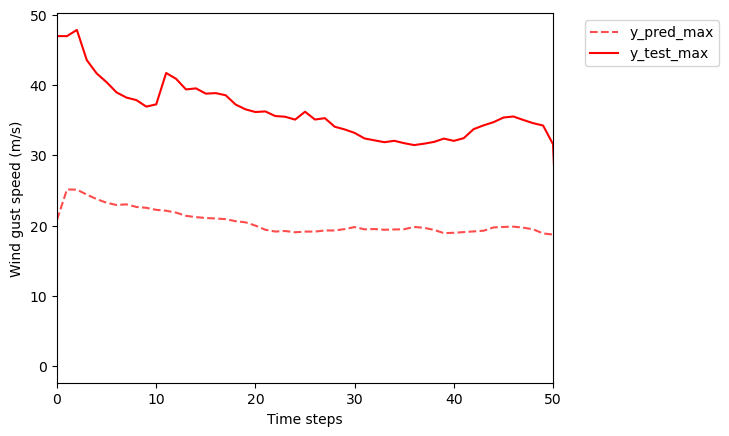

In [9]:
#y_pred = model_Gia_3d.predict(X_test)
'''
value_to_replace = -1e9
new_value = 0

y_test_reshaped = y_test.reshape(y_test.shape[0]*y_test.shape[1])

y_test_0 = [new_value if x == value_to_replace else x for x in y_test_reshaped]
y_test_0 = np.array(y_test_0)

y_test_0 = y_test_0.reshape(y_test.shape[0],y_test.shape[1])
'''
stats = ['max','min','mean','std']
colors = ['red', 'green', 'orange', 'blue']
for storm_n in range(0,len(y_pred_2)):
    for stat in stats:
        num_stat = stats.index(stat)
                # Find the index where len(y_test[storm_n, :, num_stat] == 0) is zero
        indices = np.where(y_true[storm_n, :, num_stat] == 0)[0]-1
        if len(indices) > 0:
            xlim_index = indices[0]
        else:
            xlim_index = len(y_true[storm_n, :, num_stat])
        color = colors[num_stat % len(colors)]
        plt.plot(y_pred_2[storm_n, :, num_stat], label=f'y_pred_{stat}', linestyle='--', color=color, alpha=0.7)
        plt.plot(y_true[storm_n, :, num_stat], label=f'y_test_{stat}', color=color)
        plt.xlim(0,xlim_index)
        plt.xlabel('Time steps')
        plt.ylabel('Wind gust speed (m/s)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.show()
    # save the plot
    plt.tight_layout()
    plt.savefig(f'{path}case_study/LSTM_3d_WSE_logs_2/plot_{storm_n}_tuned_single_stat.png')
    plt.close()

# calculate the RMSE

rms = (mean_squared_error(y_true[:,:xlim_index,:].ravel(),y_pred_2[:,:xlim_index,:].ravel()))**0.5
r2 = r2_score(y_true[:,:xlim_index,:].ravel(),y_pred_2[:,:xlim_index,:].ravel())
mae = mean_absolute_error(y_true[:,:xlim_index,:].ravel(),y_pred_2[:,:xlim_index,:].ravel())
mape = mean_absolute_percentage_error(y_true[:,:xlim_index,:].ravel(),y_pred_2[:,:xlim_index,:].ravel())
print('rms',rms)
print('r2_score',r2)
print('mae',mae) 
print('mape',mape)

In [3]:
class WeightedMSE(tf.keras.losses.Loss):
    """ 
    Calculate a weighted MSE. This loss gives you control to weight the 
    pixels that are > 0 differently than the pixels that are 0 in y_true. This
    class is subclassed from tf.keras.lossess.Loss to hopefully enable 
    'stateful'-ness.
 
    weights[0] is the weight for non-zero pixels
    weights[1] is the weight for zero pixels.
    """
    def __init__(self, weights=[1.0, 1.0], name="custom_mse", **kwargs):
        super(WeightedMSE, self).__init__(name=name, **kwargs)
        # store weights
        self.w1 = weights[0]
        self.w2 = weights[1]

    def call(self, y_true, y_pred):
        # build weight_matrix 
        ones_array = tf.ones_like(y_true)
        weights_for_nonzero = tf.math.multiply(ones_array, self.w1)
        weights_for_zero = tf.math.multiply(ones_array, self.w2)
        weight_matrix = tf.where(tf.greater(y_true, 0), weights_for_nonzero, weights_for_zero)
        loss = tf.math.reduce_mean(tf.math.multiply(weight_matrix, tf.math.square(tf.math.subtract(y_pred, y_true))))
        return loss

In [7]:
# load the non-tuned model and the tuned model

#model_WSE_G = tf.keras.models.load_model(f'{path}case_study/LSTM_3d_WSE_logs_2/model_WSE_2.keras', custom_objects={'WeightedMSE': WeightedMSE})
model_optuna = tf.keras.models.load_model(f'{path}case_study/LSTM_3d_WSE_logs_2/model_optuna_WSE_single_stat.keras', custom_objects={'WeightedMSE': WeightedMSE})

In [22]:
# use shap to explain the model

predict_X_test = model_WSE_G.predict(X_test)
predict_X_test_optuna = model_optuna.predict(X_test)

background = X_test[:100]

# Create a SHAP explainer TAKES 1 HOUR TO RUN
explainer = shap.KernelExplainer(model_WSE_G.predict, X_test[:100])  # Use a small subset for speed model_Gia_2

# Compute SHAP values for a subset of the data
shap_values = explainer.shap_values(X_test[:100])

# Plot SHAP summary
shap.summary_plot(shap_values, X_test[:100])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


DimensionError: Instance must have 1 or 2 dimensions!

In [29]:
from sklearn.inspection import permutation_importance

# Predict on your test set
predictions = model_WSE_G.predict(X_test)

# Compute permutation importance (reshaping input might be necessary)
results = permutation_importance(model_WSE_G, X_test, y_test, n_repeats=10, random_state=42)

# Print the feature importance
print("Feature importances:", results.importances_mean)

# Plot feature importances
import matplotlib.pyplot as plt
plt.bar(range(len(results.importances_mean)), results.importances_mean)
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: Found array with dim 3. None expected <= 2.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

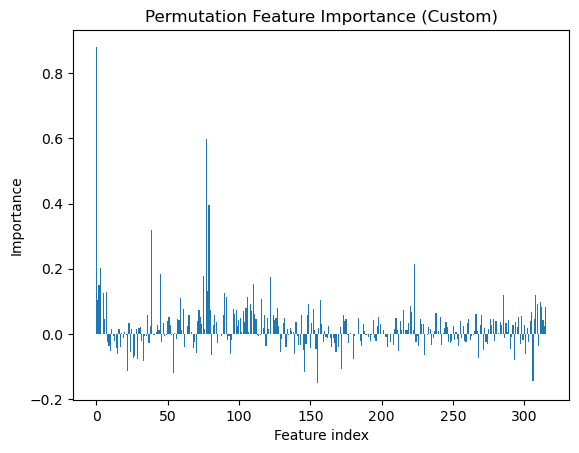

In [37]:
import numpy as np

def custom_permutation_importance(model_predict, X, y, num_repeats=10, random_state=None):
    rng = np.random.RandomState(random_state)
    baseline_predictions = model_predict(X)  # Predict with the original data
    baseline_score = np.mean((baseline_predictions - y) ** 2)  # Baseline MSE score

    importances = np.zeros(X.shape[1])  # Initialize importances to zero for each feature

    for col in range(X.shape[1]):
        scores = np.zeros(num_repeats)  # Store scores for each repeat
        for n in range(num_repeats):
            # Create a copy of X and shuffle the column
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, col])
            
            # Get predictions and calculate the new score after shuffling
            permuted_predictions = model_predict(X_permuted)
            permuted_score = np.mean((permuted_predictions - y) ** 2)  # MSE after permutation

            # The importance is how much the score worsens after permutation
            scores[n] = permuted_score - baseline_score

        # Average importance across repeats
        importances[col] = np.mean(scores)

    return importances

# Custom prediction function to handle reshaping for the LSTM model
def model_predict_reshaped(data_2d):
    num_timesteps = X_test.shape[1]  # Number of timesteps
    num_features = X_test.shape[2]   # Number of features
    
    # Calculate the number of samples from the 2D data
    num_samples = data_2d.shape[0] // num_timesteps
    
    # Reshape back to 3D (samples, timesteps, features) for LSTM
    data_3d = data_2d.reshape((num_samples, num_timesteps, num_features))
    
    # Get model predictions
    return model_optuna.predict(data_3d).reshape(-1)

# Reshape X_test from 3D (samples, timesteps, features) to 2D (samples * timesteps, features)
X_test_flattened = X_test.reshape((X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Flatten y_test to match the shape of predictions
y_test_flattened = y_test.flatten()

# Call the custom permutation importance function
importances = custom_permutation_importance(model_predict_reshaped, X_test_flattened, y_test_flattened, num_repeats=10, random_state=42)

# Display the feature importances
print("Feature importances:", importances)

# Plot the feature importances
import matplotlib.pyplot as plt
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance (Custom)')
plt.show()

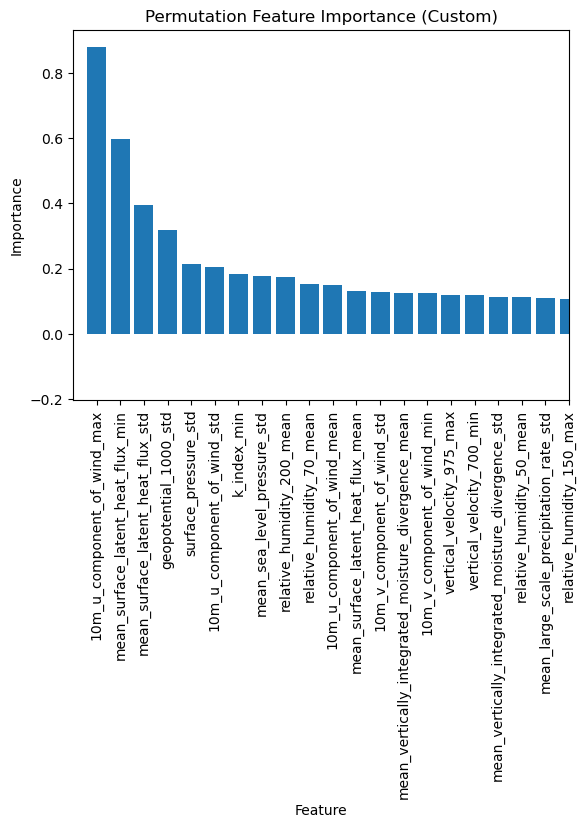

In [38]:
# now in order of importance with the name of the features 

# Get the feature names from the DataFrame
feature_names = features[0].values

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Create tick labels
tick_labels = feature_names[sorted_indices]

# Plot the feature importances
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), tick_labels, rotation=90)
plt.xlim(-1,20)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance (Custom)')
plt.show()

# save the plot as a giant image


In [18]:
import timeshap

features_series = features.squeeze()

from timeshap.utils import calc_avg_event
average_event = calc_avg_event(X_train, numerical_feats = , categorical_feats=[])

TypeError: calc_avg_event() missing 1 required positional argument: 'numerical_feats'